## Convolutional Kernel Modification
In this notebook the default convolutional network was trained and tested as well as a modified verion of it.

The modification consists in changing every convolutional layer with several branches of smaller conv. neurons. See below for details on the architecture.

As for the performance of the modified network, it didn't demonstrate good results achieveing ~55% accuracy (default setup is 65%). Note that with moderate amount of initial layer capacity the pre-training check required about 400 epochs to converge when trying to overfit small portion of data. At the same time, due to lack of computational resources and complexity of the produced network the initial layer capacity (n) as well as the number of branches (k) were lowered for the training procedure.

As a result, it is possible that the performance of the modified network could be improved by setting the initial layer capacity higher and stretching the training time, assuming everything else on my part was done correctly.

## Preparing the data

In [1]:
import numpy as np
from cifar import load_cifar10

# load cifar-10 dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10("cifar_data")

In [2]:
import theano
import theano.tensor as T
import lasagne

# input data
input_X = T.tensor4("input X")

# input dimension
input_shape = [None,3,32,32]

# target labels
target_y = T.vector("target Y", dtype='int32')

## Building the network
The default network architecture.

In [9]:
comp_scale = 8  # initial number of filters for conv layers

# GlorotUniform is the default weights initialization
# 0.01 is the default leakiness for leaky_rectify nonlinearity

input_layer = lasagne.layers.InputLayer(shape = input_shape, 
                                        input_var = input_X, 
                                        name = 'input')

conv_1 = lasagne.layers.Conv2DLayer(input_layer, 
                                    num_filters = comp_scale, 
                                    filter_size = (3, 3), 
                                    nonlinearity = lasagne.nonlinearities.leaky_rectify, 
                                    name = 'conv_1')

conv_2 = lasagne.layers.Conv2DLayer(conv_1, 
                                    num_filters = comp_scale, 
                                    filter_size = (3, 3), 
                                    nonlinearity = lasagne.nonlinearities.leaky_rectify, 
                                    name = 'conv_2')

max_pool_1 = lasagne.layers.MaxPool2DLayer(conv_2, 
                                           pool_size = 2, 
                                           name = 'max_pool_1')

conv_3 = lasagne.layers.Conv2DLayer(max_pool_1, 
                                    num_filters = int(comp_scale * 1.5), 
                                    filter_size = (3, 3), 
                                    nonlinearity = lasagne.nonlinearities.leaky_rectify, 
                                    name = 'conv_3')

conv_4 = lasagne.layers.Conv2DLayer(conv_3, 
                                    num_filters = int(comp_scale * 1.5), 
                                    filter_size = (3, 3), 
                                    nonlinearity = lasagne.nonlinearities.leaky_rectify, 
                                    name = 'conv_4')

max_pool_2 = lasagne.layers.MaxPool2DLayer(conv_4, 
                                           pool_size = 2, 
                                           name = 'max_pool_2')

conv_5 = lasagne.layers.Conv2DLayer(max_pool_2, 
                                    num_filters = comp_scale * 2, 
                                    filter_size = (3, 3), 
                                    nonlinearity = lasagne.nonlinearities.leaky_rectify, 
                                    name = 'conv_5')

conv_6 = lasagne.layers.Conv2DLayer(conv_5, 
                                    num_filters = comp_scale * 2, 
                                    filter_size = (3, 3), 
                                    nonlinearity = lasagne.nonlinearities.leaky_rectify, 
                                    name = 'conv_6')

global_pool = lasagne.layers.GlobalPoolLayer(conv_6, 
                                             name = 'global_pool')

dense_output = lasagne.layers.DenseLayer(global_pool, 
                                         num_units = 10, 
                                         nonlinearity = lasagne.nonlinearities.softmax, 
                                         name = 'output')

In [10]:
y_predicted = lasagne.layers.get_output(dense_output)

all_weights = lasagne.layers.get_all_params(dense_output, trainable=True)

loss = lasagne.objectives.categorical_crossentropy(y_predicted, target_y).mean()

accuracy = lasagne.objectives.categorical_accuracy(y_predicted, target_y).mean()


# weights update
updates = lasagne.updates.adamax(loss, all_weights)


# a function that accepts X and y, returns loss functions and performs weight updates
train_fun = theano.function([input_X, target_y], [loss, accuracy], updates = updates)


# deterministic prediciton
y_predicted_det = lasagne.layers.get_output(dense_output, deterministic = True)

# deterministic accuracy
accuracy_det = lasagne.objectives.categorical_accuracy(y_predicted_det, target_y).mean()

# function that computes that accuracy
accuracy_fun = theano.function([input_X, target_y], accuracy_det)

## Auxiliary functions

In [5]:
def iterate_minibatches(X, y, batchsize):    
    '''Return an iterable of (X_batch, y_batch) batches of images and answers for them.'''
    
    size = len(X)
    indices = np.arange(size)
    np.random.shuffle(indices)
    
    for start_idx in range(0, size, batchsize):
        excerpt = indices[start_idx : start_idx + batchsize]
        yield X[excerpt], y[excerpt]

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

def update_progress(epoch, num_epochs, 
                  time_since_update, duration, 
                  train_err, train_acc, val_acc, 
                  train_batches, val_batches, 
                  log):
    '''Display training progress. Update every second.'''
    
    if len(log) < num_epochs:
        if train_batches > 0:
            log.append([train_err/train_batches, train_err, train_acc, val_acc, train_batches, val_batches, duration])
        else:
            log.append([0, train_err, train_acc, val_acc, train_batches, val_batches, duration])

    if time_since_update > 1:
        
        clear_output(True)

        print("Epoch {} of {} took {:.3f} s".format(epoch + 1, num_epochs, duration))
        print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
        print("  train accuracy:\t\t{:.2f} %".format(train_acc / train_batches * 100))
        print("  validation accuracy:\t\t{:.2f} %".format(val_acc / val_batches * 100))

        plt.figure(figsize=[8,4])
        plt.plot(zip(*log)[0], label='Loss')
        plt.ylim(0, 2.5)
        plt.legend(loc='best')
        plt.grid()
        time_since_update = 0

        plt.show()
    
    return time_since_update

In [7]:
import time

def train_network(num_epochs, batch_size, log, X_train, y_train, X_val, y_val, X_test, y_test):
    '''Perform training of a network.'''
    
    time_since_update = 0

    for epoch in range(num_epochs):
        # do a full pass over the training data
        train_err = 0
        train_acc = 0
        train_batches = 0
        start_time = time.time()
        for batch in iterate_minibatches(X_train, y_train, batch_size):
            inputs, targets = batch
            train_err_batch, train_acc_batch= train_fun(inputs, targets)
            train_err += train_err_batch
            train_acc += train_acc_batch
            train_batches += 1

        # do a full pass over the validation data
        val_acc = 0
        val_batches = 0
        for batch in iterate_minibatches(X_val, y_val, batch_size):
            inputs, targets = batch
            val_acc += accuracy_fun(inputs, targets)
            val_batches += 1

        time_since_update += time.time() - start_time
        time_since_update = update_progress(epoch, num_epochs, 
                                            time_since_update, 
                                            time.time() - start_time, 
                                            train_err, train_acc, val_acc, 
                                            train_batches, val_batches, 
                                            log)

    # log == [train_err/train_batches, train_err, train_acc, val_acc, train_batches, val_batches, duration]

    last_entry = log[-1]  # plot the last epoch in case it didn't show

    time_since_update = update_progress(num_epochs - 1, num_epochs, 
                                        2, 
                                        last_entry[-1], 
                                        last_entry[1], last_entry[2], last_entry[3], 
                                        last_entry[4], last_entry[5], 
                                        log)
    # evaluate on the test data
    test_acc = 0
    test_batches = 0
    for batch in iterate_minibatches(X_test, y_test, 500):
        inputs, targets = batch
        acc = accuracy_fun(inputs, targets)
        test_acc += acc
        test_batches += 1
    print("Final results:")
    print("  test accuracy:\t\t{:.2f} %".format(test_acc / test_batches * 100))
    print

## Sanity checks

#### Checking that the loss is reasonable
Loss should be ~2.3 without any regularization.

In [8]:
check_input, check_target = iterate_minibatches(X_train, y_train, 50).next()
check_loss, check_acc = train_fun(check_input, check_target)
print check_loss

2.29487910313


#### Making sure we can overfit a small portion of the data
i.e. get ~0 loss and ~100% accuracy.

Epoch 100 of 100 took 0.076 s
  training loss:		0.011280
  train accuracy:		100.00 %
  validation accuracy:		100.00 %


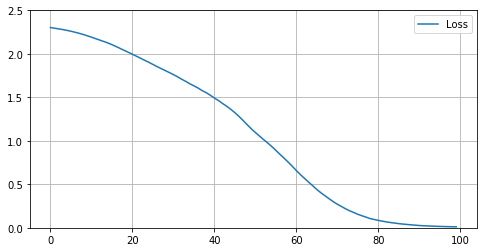

Final results:
  test accuracy:		100.00 %

CPU times: user 10.5 s, sys: 962 ms, total: 11.4 s
Wall time: 11 s


In [11]:
%%time

X_tiny = X_train[:20]
y_tiny = y_train[:20]

log_tiny = [] #[train_err/train_batches, train_err, train_acc, val_acc, train_batches, val_batches, duration]

train_network(100, 20, log_tiny, X_tiny, y_tiny, X_tiny, y_tiny, X_tiny, y_tiny)

## Training the default network
Network weights are reinitialized beforehand.

Epoch 100 of 100 took 116.528 s
  training loss:		0.806457
  train accuracy:		71.11 %
  validation accuracy:		66.16 %


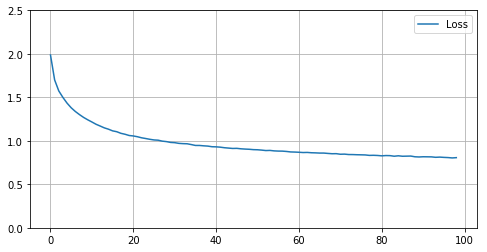

Final results:
  test accuracy:		65.17 %

CPU times: user 3h 19min 19s, sys: 19min 21s, total: 3h 38min 40s
Wall time: 3h 15min 5s


In [8]:
%%time

log_default = []

train_network(100, 50, log_default, X_train, y_train, X_val, y_val, X_test, y_test)

In [9]:
# save the network weights to a file
np.savez('network_default.npz', *lasagne.layers.get_all_param_values(conv_1))

# to load them again later on:
# with np.load('network_default.npz') as f:
#     param_values = [f['arr_%d' % i] for i in range(len(f.files))]
# lasagne.layers.set_all_param_values(network, param_values)

In [20]:
# save the training log to a file
np.save('log_default.npy', log_default)

## Modified network
Instead of every n-filter conv layer the following structure is implemented:<br>
`concatLayer([ incoming -> conv1x1(m) -> conv3x3(m) for _ in range(k) ])`<br>
where `k` is the number of branches a single input is spread into, and `m = n/k`.

In [16]:
gain_leaky = np.sqrt(2/(1+0.01**2))  # gain value for Glorot init with Leaky ReLU, alpha = 0.01
print gain_leaky

1.414142857


In [50]:
comp_scale = 4    # initial number of filters for conv layers
num_branches = 2  # number of branches a single conv layer is turned into
branch_cap = int(comp_scale/num_branches)  # number of filters for a conv layer of a single branch
gain_branch = 1.0/num_branches

# GlorotUniform is the default weights initialization
# 0.01 is the default leakiness for leaky_rectify nonlinearity

input_layer = lasagne.layers.InputLayer(shape = input_shape, 
                                        input_var = input_X)

# instead of conv_1:
branches_1_1 = []
branches_1_2 = []
for i in range(num_branches):
    branches_1_1.append(lasagne.layers.Conv2DLayer(input_layer, 
                                                   num_filters = branch_cap, 
                                                   filter_size = (1, 1), 
                                                   W = lasagne.init.GlorotUniform(gain = gain_leaky), 
                                                   nonlinearity = lasagne.nonlinearities.leaky_rectify))
    branches_1_2.append(lasagne.layers.Conv2DLayer(branches_1_1[i], 
                                                   num_filters = branch_cap, 
                                                   filter_size = (3, 3), 
                                                   W = lasagne.init.GlorotUniform(gain = gain_branch), 
                                                   nonlinearity = lasagne.nonlinearities.leaky_rectify))
concat_1 = lasagne.layers.ConcatLayer(branches_1_2)


# instead of conv_2:
branches_2_1 = []
branches_2_2 = []
for i in range(num_branches):
    branches_2_1.append(lasagne.layers.Conv2DLayer(concat_1, 
                                                   num_filters = branch_cap, 
                                                   filter_size = (1, 1), 
                                                   W = lasagne.init.GlorotUniform(gain = gain_leaky), 
                                                   nonlinearity = lasagne.nonlinearities.leaky_rectify))
    branches_2_2.append(lasagne.layers.Conv2DLayer(branches_2_1[i], 
                                                   num_filters = branch_cap, 
                                                   filter_size = (3, 3), 
                                                   W = lasagne.init.GlorotUniform(gain = gain_branch), 
                                                   nonlinearity = lasagne.nonlinearities.leaky_rectify))
concat_2 = lasagne.layers.ConcatLayer(branches_2_2)


max_pool_1 = lasagne.layers.MaxPool2DLayer(concat_2, 
                                           pool_size = 2)

# instead of conv_3:
branches_3_1 = []
branches_3_2 = []
for i in range(num_branches):
    branches_3_1.append(lasagne.layers.Conv2DLayer(max_pool_1, 
                                                   num_filters = int(branch_cap * 1.5),
                                                   filter_size = (1, 1), 
                                                   W = lasagne.init.GlorotUniform(gain = gain_leaky), 
                                                   nonlinearity = lasagne.nonlinearities.leaky_rectify))
    branches_3_2.append(lasagne.layers.Conv2DLayer(branches_3_1[i], 
                                                   num_filters = int(branch_cap * 1.5), 
                                                   filter_size = (3, 3), 
                                                   W = lasagne.init.GlorotUniform(gain = gain_branch), 
                                                   nonlinearity = lasagne.nonlinearities.leaky_rectify))
concat_3 = lasagne.layers.ConcatLayer(branches_3_2)


# instead of conv_4:
branches_4_1 = []
branches_4_2 = []
for i in range(num_branches):
    branches_4_1.append(lasagne.layers.Conv2DLayer(concat_3, 
                                                   num_filters = int(branch_cap * 1.5),
                                                   filter_size = (1, 1), 
                                                   W = lasagne.init.GlorotUniform(gain = gain_leaky), 
                                                   nonlinearity = lasagne.nonlinearities.leaky_rectify))
    branches_4_2.append(lasagne.layers.Conv2DLayer(branches_4_1[i], 
                                                   num_filters = int(branch_cap * 1.5), 
                                                   filter_size = (3, 3), 
                                                   W = lasagne.init.GlorotUniform(gain = gain_branch), 
                                                   nonlinearity = lasagne.nonlinearities.leaky_rectify))
concat_4 = lasagne.layers.ConcatLayer(branches_4_2)


max_pool_2 = lasagne.layers.MaxPool2DLayer(concat_4, 
                                           pool_size = 2)

# instead of conv_5:
branches_5_1 = []
branches_5_2 = []
for i in range(num_branches):
    branches_5_1.append(lasagne.layers.Conv2DLayer(max_pool_2, 
                                                   num_filters = branch_cap * 2,
                                                   filter_size = (1, 1), 
                                                   W = lasagne.init.GlorotUniform(gain = gain_leaky), 
                                                   nonlinearity = lasagne.nonlinearities.leaky_rectify))
    branches_5_2.append(lasagne.layers.Conv2DLayer(branches_5_1[i], 
                                                   num_filters = branch_cap * 2, 
                                                   filter_size = (3, 3), 
                                                   W = lasagne.init.GlorotUniform(gain = gain_branch), 
                                                   nonlinearity = lasagne.nonlinearities.leaky_rectify))
concat_5 = lasagne.layers.ConcatLayer(branches_5_2)


# instead of conv_6:
branches_6_1 = []
branches_6_2 = []
for i in range(num_branches):
    branches_6_1.append(lasagne.layers.Conv2DLayer(concat_5, 
                                                   num_filters = branch_cap * 2,
                                                   filter_size = (1, 1), 
                                                   W = lasagne.init.GlorotUniform(gain = gain_leaky), 
                                                   nonlinearity = lasagne.nonlinearities.leaky_rectify))
    branches_6_2.append(lasagne.layers.Conv2DLayer(branches_6_1[i], 
                                                   num_filters = branch_cap * 2, 
                                                   filter_size = (3, 3), 
                                                   W = lasagne.init.GlorotUniform(gain = gain_branch), 
                                                   nonlinearity = lasagne.nonlinearities.leaky_rectify))
concat_6 = lasagne.layers.ConcatLayer(branches_6_2)


global_pool = lasagne.layers.GlobalPoolLayer(concat_6)

dense_output = lasagne.layers.DenseLayer(global_pool, 
                                         num_units = 10, 
                                         nonlinearity = lasagne.nonlinearities.softmax)

In [51]:
y_predicted = lasagne.layers.get_output(dense_output)

all_weights = lasagne.layers.get_all_params(dense_output, trainable=True)

loss = lasagne.objectives.categorical_crossentropy(y_predicted, target_y).mean()

accuracy = lasagne.objectives.categorical_accuracy(y_predicted, target_y).mean()


# weights update
updates = lasagne.updates.adamax(loss, all_weights)


# a function that accepts X and y, returns loss functions and performs weight updates
train_fun = theano.function([input_X, target_y], [loss, accuracy], updates = updates)


# deterministic prediciton
y_predicted_det = lasagne.layers.get_output(dense_output, deterministic = True)

# deterministic accuracy
accuracy_det = lasagne.objectives.categorical_accuracy(y_predicted_det, target_y).mean()

# function that computes that accuracy
accuracy_fun = theano.function([input_X, target_y], accuracy_det)

## Sanity checks

#### Checking that the loss is reasonable
Loss should be ~2.3 without any regularization.

In [22]:
check_input, check_target = iterate_minibatches(X_train, y_train, 50).next()
check_loss, check_acc = train_fun(check_input, check_target)
print check_loss

2.30258549707


#### Making sure we can overfit a small portion of the data
i.e. get ~0 loss and ~100% accuracy.

Epoch 400 of 400 took 0.050 s
  training loss:		0.173023
  train accuracy:		95.00 %
  validation accuracy:		95.00 %


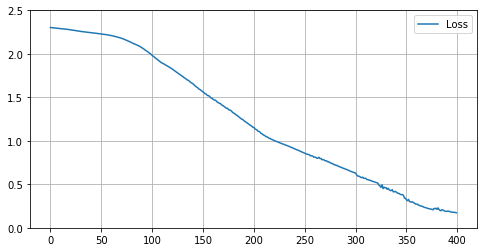

Final results:
  test accuracy:		95.00 %

CPU times: user 26.2 s, sys: 2.21 s, total: 28.4 s
Wall time: 29.1 s


In [49]:
%%time

X_tiny = X_train[:20]
y_tiny = y_train[:20]

log_tiny = [] #[train_err/train_batches, train_err, train_acc, val_acc, train_batches, val_batches, duration]

train_network(400, 20, log_tiny, X_tiny, y_tiny, X_tiny, y_tiny, X_tiny, y_tiny)

## Training the modified network

Epoch 400 of 400 took 89.299 s
  training loss:		1.205077
  train accuracy:		57.08 %
  validation accuracy:		55.37 %


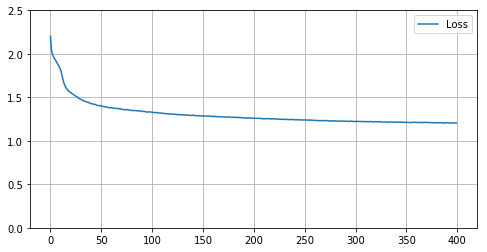

Final results:
  test accuracy:		54.54 %

CPU times: user 8h 7min 15s, sys: 1h 46min 27s, total: 9h 53min 43s
Wall time: 9h 56min 4s


In [52]:
%%time

log_branches = []

train_network(400, 50, log_branches, X_train, y_train, X_val, y_val, X_test, y_test)

In [53]:
np.savez('network_branches.npz', *lasagne.layers.get_all_param_values(input_layer))

In [54]:
np.save('log_branches.npy', log_branches)